## R(t)

Calculo la evolución del bubston desde que tiene N_{e max} electrones hasta que el cluster formado por n_bubstons está en su máxima expansión.

La diferencia con el archivo _old es que en aquel tengo cuentas extras mal hechas y, además, las hice con algunos errores (factores 2/3) debido a los errores que encontré en el paper de Bunkin
Además, intenté juntar todas las evoluciones empleando las mismas funciones

El programa está construido en el sistema de unidades CGS:
https://es.wikipedia.org/wiki/Sistema_Cegesimal_de_Unidades


In [44]:
#Importo librerías
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.integrate import quad #Para calcular integrales numéricamente
from math import pi
from scipy.optimize import fsolve #Para resolver ecuaciones algebraicas

### Parámetros generales

In [45]:
#En CGS:
#Parámetros de la ecuación diferencial
p_inf = 0.925 #Presión ambiente en el infinito en [atm]. Son 0.925 atm correspondientes a Bariloche. 
p_inf = p_inf*(101325)*(1/0.1) #en [baria] (CGS). Conversión: (atm)(101325 Pa/atm)(baria/ 0.1 Pa)
c_L = 1415.1 #velocidad del sonido del líquido en [m/s] para agua D2O a Tinf=35+273.15. Lo copié del código de Gabriela.
c_L = c_L*100 #en [cm/s] (CGS). Conversión (m/s)*(100 cm/m)
rho_L = 1101.8 #densidad del líquido en la superficie de la burbuja en [kg/m3] para agua D2O a Tinf=35+273.15. Lo copié del código de Gabriela. 
rho_L = rho_L*(1/100)**3*(1000) #en [g/cm3] (CGS). Conversión (kg/m3)*(1m/100cm)^3*(1000g/1Kg)

#Parámetros de la presión eléctrica p_e
#Condiciones iniciales de la ecuación diferencial
Delta = 6 #Energía mecánica para arrancar un electrón de la pared en [eV]
T_e_bubs_ini = Delta/3 #Temperatura de los electrones dentro de la burbuja en [eV]. Conversión: (ev)*()
T_e_bubs_ini = T_e_bubs_ini*(1.602176565e-19)*(1/1e-7) #en [erg] (CGS). Conversión (1ev)(1.602176565e-19J/1ev)*(1erg/1e-7 J)

q_e = -1.602176634e-19 #carga del electrón en [Coulomb]
q_e = q_e*(1/3.336641e-10) #en [Fr] (CGS). Conversión (C)*(Fr/3.336641e-10 C)

R0 = 1e-6 #Radio inicial de un bubston en [cm]. Este valor lo saqué del supuesto inicial del Bunkin


#Parámetros para determinar el radio de Debye de un electrolito dentro de un líquido
# T_L = 35+273.15 #temperatura del líquido. La obtuve del código de Gabriela. A este valor corresponden rho_L y c_L
# Epsilon0 = 8.8541878128e-12 # Permitividad del vacío en [F/m] (SI)
# Epsilon0 = Epsilon0*(1/100)*(1/1.113e-12) #en [cm] (CGS). Conversión (F/m)*(1m/100cm)*(1cm/1.113e-12F) En CGS el "cm" es una medida de capacidad eléctrica (F faradio en SI)
# Epsilon_L = 80.2*Epsilon0 #ESTE VALOR LO SAQUÉ DE WIKIPEDIA. DEPENDE DE T y se puede mejorar
# n_i0 =  3e15 #en [cm^-3] (CGS). No sé qué representa, se puede mejorar


a_i = 2e-5 #radio de Debye de un electrolito dentro de un líquido en [cm]. Valor extraído del Bunkin
R1 = a_i #radio de los bubstons tal que comienzan a tocarse entre sí

#Parámetros del cluster
N_bubston = 1e8 #nro de bubston dentro de un cluster. Valor extraído del Bunkin

Beta = 0.74 #Factor de empaquetamiento de los bubstons en el cluster. Valor extraído del Bunkin
R_cl_ini = a_i*(N_bubston/Beta)**(1/3) #radio inicial del núcleo formado por N_bubston bubstons en [cm] (CGS)


### Evolución desde $N_{e max}$ hasta R = R1

Parto de un bubston con radio R_0, temperatura T_e = Delta/3 y N_{e max} electrones en su interior. Calculo evolución del radio a partir de la ecuación fluidodinámica, empleando como presión la presión eléctrica. En base a que el proceso es cuasiestático (suposición de Bunkin), se consideró que todos los parámetros que dependen de R0 ahora lo hacen de R (radio de la burbuja)

#### Definición de funciones

In [46]:
def T_e(R):
    #Temperatura bajo el régimen de autoconsistencia
    return T_e_bubs_ini*R0/R

In [47]:
def N_emax(R):
    #Nro máximo de electrones
    return 64/9*(T_e(R)*R/q_e**2)**2

In [48]:
def x(R):
    #factor x = R/a_e. Resulta ser el mismo que el factor x del Bunkin. Recordar que por consideraciones cuasiestáticas lo que antes dependía de R0 ahora lo hace de R.
    def ec_de_x(x):
        #Esta ec está definida en el Bunkin
        return T_e(R)*R/q_e**2*(x*np.cosh(x)- np.sinh(x))/(x) - N_emax(R)
    return fsolve(ec_de_x, 4)[0]

def a_e(R):
    #Electron Debye Radius. a_e es solución de la ecuación de N_e asumiendo que N_e está dado por T_e, R0 y q_e al considerar x grande
    return R/x(R)


In [49]:
#Defino la densidad de electrones

def Vol(R):
    #Volumen de una esfera del radio R
    return 4/3*pi*R**3

def n_e0(R):
    #Densidad en r = 0
    #R: radio de la burbuja
    return T_e(R)/(4*pi*q_e**2*a_e(R)**2)

def n_e_R(R):
    #Densidad en r = R
    #R: radio de la burbuja
    return n_e0(R)*np.sinh(R/a_e(R))/(R/a_e(R))

def n_e_mean(R):
    #Densidad promedio en la burbuja
    #R: radio de la burbuja
    return N_emax(R)/Vol(R)


In [50]:
def E(R):
    #Campo eléctrico debido a la distribución de carga. No es la misma expresión que el Bunkin porque en el Bunkin están mal algunos factores
    ae = a_e(R)
    x = R/ae
    return T_e(R)*ae/(q_e*R**2)*(np.sinh(x) - (x)*np.cosh(x))

In [51]:
#Defino la presión eléctrica

def p_gas(R):
    #Presión producida por el gas de electrones
    return 2/3*n_e_R(R)*T_e(R)

def p_coul(R):
    #Presión electrostática producida por la distribución de carga (electrones)
    return E(R)**2/(8*pi)

def p_e(R):
    #Presión total producida por los electrones
    return p_gas(R) + p_coul(R)

#### Sistema de ecuaciones diferenciales

In [52]:
def dydt(t,y):
    #Sistema de ecuaciones de primer orden para la evolución del radio en función del tiempo. Entiéndase y = (R, Rp) = (R, v_R)
    v_R = y[1]
    R = y[0]

    #Expreso dydt_0 = dR/dt = v_R
    dydt_0 = v_R

    #Expreso dydt_2 = d(v_R/dt) = d2(R)/dt2
    dydt_1 = (p_e(R)/rho_L - 3/2*v_R**2)/R

    return [dydt_0, dydt_1]


In [53]:
#Defino la condición de stop de la evolución
def event_bubs(t, y):
    #Evoluciona hasta que R = R1 = l/2 \approx a_i
    return y[0] - a_i #Da cero cuando la condición ocurre


#### Resultados

In [54]:
#Resuelvo el sistema dy/dt usando solve_ivp
t_ini = 0
t_max = 5e-9 #70 ns
y_ini = [R0, 0] #Condición inicial
rtol = 1e-12 #tolerancia relativa para el método numérico
sol = solve_ivp(dydt, [t_ini, t_max], y_ini, method = "DOP853", rtol = rtol, atol = rtol, events = event_bubs)
#asumo que el problema no es stiff


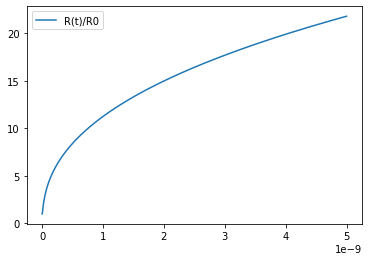

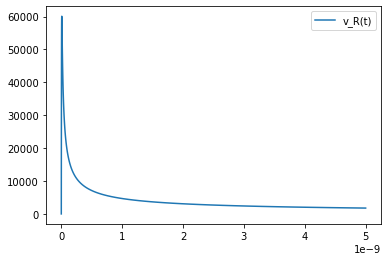

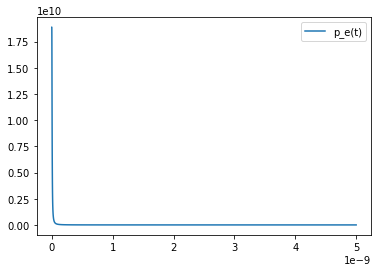

In [55]:
#Grafico
plt.plot(sol.t, sol.y[0]/R0, label = "R(t)/R0")
plt.legend()
plt.show()

plt.plot(sol.t, sol.y[1], label = "v_R(t)")
plt.legend()
plt.show()

p_e_array = np.zeros(len(sol.t))
for i in range(len(sol.t)):
    p_e_array[i] = p_e(sol.y[0][i])

plt.plot(sol.t, p_e_array, label = "p_e(t)")
plt.legend()
plt.show()


In [56]:
print("El valor R = R1 = a_i es: ", sol.y_events[0][0][0])
print("que ocurre a tiempo t = ", sol.t_events[0][0])

El valor R = R1 = a_i es:  1.9999999971671374e-05
que ocurre a tiempo t =  4.044391184745951e-09


### Evolución desde formación del cluster instantánea hasta máxima expansión

Parto de una bubrbuja de radio R = R_cl_ini cuya pared se expande a velocidad v_R dada por la energía coulombiana presente en la burbuja. Esta energía se calcula a partir del campo eléctrico en el interior de la burbuja. Se considera que la temperatura de los electrones es aquella a R = R1, es decir, "los electrones poseen la misma temperatura". Además, tmb cambia el nro de electrones $N_e$ dentro de la burbuja. Ahora es $N_{e max} * N_{bubstons}$ donde $N_{e max}$ correspondía al proceso anterior

#### Redefinición de funciones

In [57]:
#Redefino x. A diferencia de antes, la temperatura se considera igual a aquella en R = R1, pero el radio en la fórmula se toma como R = R_cl_ini. También cambia el nro máximo de electrones
def x(R):
    def ec_de_x(x):
        return T_e(R1)*R/q_e**2*(x*np.cosh(x)- np.sinh(x))/(x) - N_emax(R)*N_bubston
    return fsolve(ec_de_x, 17)[0]

#Redefino el campo eléctrico por la misma razón que antes. Además, voy a integrarlo en r así que necesito que tenga dos variables: r y R_burbuja
def E(r,R):
    ae = a_e(R)
    x = r/ae
    return T_e(R1)*ae/(q_e*r**2)*(np.sinh(x) - (x)*np.cosh(x))

#### Cálculo de la velocidad $v_R$

In [58]:
#Calculo la energía cinética a t=0

def W_coulomb(R_cl_ini):

    #Defino la función a integrar para calcular W_coulomb
    def f(r):
        return r**2*E(r, R_cl_ini)**2

    #Integro
    return 1/2*quad(f,0.,R_cl_ini)[0]

print(W_coulomb(R_cl_ini))

# W_coulomb = 6.3e3 # [ergios] (CGS)

#Calculo la volocidad a t=0 a partir de la igualdad E_cin = W_coulomb
v_R0 = np.sqrt(W_coulomb(R_cl_ini)/(2*pi*rho_L*R_cl_ini**3))
print(v_R0)

6023.164857429956
28368.86256179598


In [59]:
# #Testeo: no entiendo bien cuál es la fórmula que usé para calcular la velocidad.
# #Entiendo que es W_{kin} = W_{coul}, pero para eso tiene que estar la masa del gas dentro del bubston y no está eso.
# v_R0 = np.sqrt(W_coulomb(R_cl_ini)/(2*rho_L*Vol(R_cl_ini)))
# print(v_R0)
#ESTÁ MAL ESTO. ESTABA USANDO MAL LA FÓRMULA PARA LA ENERGÍA CINÉTICA!

24568.155654984606


In [60]:
#Por otro lado, esto debería ser consistente con el número de moléculas de gas en el interior
# N_gas = N_bubston*200
# Na =  6.02214076e23#nro de Avogadro
# m_H2O = 18/Na #en [g]
# m_gas = N_gas*m_H2O
# v_R0 = np.sqrt(W_coulomb(R_cl_ini)/(2*m_gas))
# print(v_R0)

70977643.77304594


#### Sistema de ecuaciones diferenciales

In [61]:
#Defino la condición límite
def event_cluster(t,y):
    return y[1] - 0 #Que pare cuando la velocidad se hace cero (máxima expansión)

def dydt(t,y):
    #Sistema de ecuaciones de primer orden para la evolución del radio en función del tiempo. Entiéndase y = (R, Rp) = (R, v_R)
    v_R = y[1]
    R = y[0]

    #Expreso dydt_0 = dR/dt = v_R
    dydt_0 = v_R

    #Para dydt_2 = d(v_R/dt) = d2(R)/dt2 hay 2 posibilidades
    #(1) usar la ecuación diferencial de la tesis de Gabriela
    #(2) usar la ecuación diferencial del paper de Bunkin que es una aproximación de la ecuación diferencial de Gabriela

    dydt_1 = ((-p_inf)/(rho_L) - 3/2*v_R**2)/R

    return [dydt_0, dydt_1]

#### Resultados

In [62]:
#Resuelvo el sistema dy/dt usando solve_ivp
t_ini = 0
t_max = 0.002 #200e-5 #2.5e-6 #70 ns

y_ini = [R_cl_ini, v_R0] #Condición inicial
rtol = 1e-12 #tolerancia relativa para el método numérico
sol = solve_ivp(dydt, [t_ini, t_max], y_ini, method = "DOP853", rtol = rtol, atol = rtol, events = event_cluster)
#asumo que el problema no es stiff


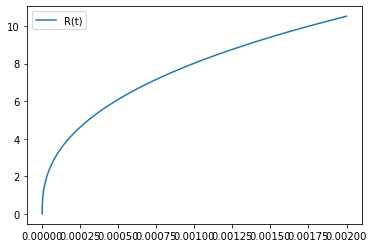

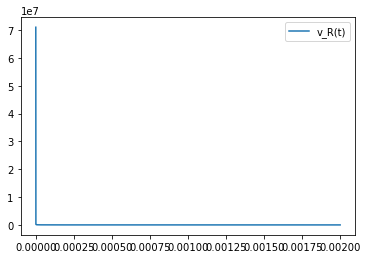

In [63]:
#Grafico
plt.plot(sol.t, sol.y[0], label = "R(t)")
plt.legend()
plt.show()

plt.plot(sol.t, sol.y[1], label = "v_R(t)")
# plt.yscale("log")
plt.legend()
plt.show()

# plt.plot(sol.t, p_electrica(n_e_mean(sol.y[0]), T_e(sol.y[0], R_cl_ini), x_cl, R_cl_ini), label = "p_electrica(t)")
# plt.legend()
# plt.show()

In [64]:
print("El máximo ocurre a R = ", sol.y_events[0][0][0], ", a t = ", sol.t_events[0][0])

IndexError: index 0 is out of bounds for axis 0 with size 0